In [25]:
# import des librairies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import clean_columns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from majority_clf import MajorityVoteClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
import scikitplot as skplt

## Classification
### Target / Features
- Target : Satisfaction
- Features : Toutes les colonnes sauf Satisfaction et id

### Preprocessing
- Features numériques : Robust scaler pour gérer les valeur hors normes
- Features catégorielles : One hot encoder, petit nombre de catégories, dimensions gérable par l'ordinateur

In [26]:
df = pd.read_csv('https://raw.githubusercontent.com/remijul/dataset/master/Airline%20Passenger%20Satisfaction.csv', sep=';')

In [27]:
df_clean = clean_columns(df).dropna() # nettoyage nom de colonnes + retirer les valeur manquantes
X = df_clean.drop(['Satisfaction', 'id'], axis=1)
y = df_clean['Satisfaction']
y = LabelEncoder().fit_transform(y) # encodage de la target

In [28]:
X_num = X.select_dtypes(exclude=[object]) # Features numériques
X_cat = X.select_dtypes(include=[object]) # Features catégorielles

In [29]:
# model
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(criterion='log_loss')
gbc = HistGradientBoostingClassifier(loss='log_loss', max_leaf_nodes=None)
rfc = RandomForestClassifier(criterion='log_loss')
xbc = XGBClassifier(objective="binary:logistic")

In [30]:
# Preprocessing + pipeline avec column_transformer
preparation = ColumnTransformer(transformers=[
    ('tf_cat', OneHotEncoder(sparse_output=False), X_cat.columns),
    ('tf_num', RobustScaler(), X_num.columns),
])

pipe_tree = Pipeline(steps=[
    ('preparation', preparation),
    ('model', tree)
])

pipe_knn = Pipeline(steps=[
    ('preparation', preparation),
    ('model', knn)
])

pipe_gbc = Pipeline(steps=[
    ('preparation', preparation),
    ('model', gbc)
])

pipe_rfc = Pipeline(steps=[
    ('preparation', preparation),
    ('model', rfc)
])

pipe_xbc = Pipeline(steps=[
    ('preparation', preparation),
    ('model', xbc)
])


In [31]:
# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [32]:
# espace des recherche des hyperparamètres
params_knn = {'model__n_neighbors': [3,5,7]}
params_gbc = {'model__max_iter': [300, 400, 500]}
params_rfc = {'model__n_estimators': [390, 400, 410]}
params_xbc = {'model__max_depth': [8, 9, 10]}

In [33]:
# grid search
grid_knn = GridSearchCV(pipe_knn, params_knn, scoring='accuracy', cv=skf, n_jobs=-1)
grid_gbc = GridSearchCV(pipe_gbc, params_gbc, scoring='accuracy', cv=skf, n_jobs=-1)
grid_xbc = GridSearchCV(pipe_xbc, params_xbc, scoring='accuracy', cv=skf, n_jobs=-1)
grid_rfc = GridSearchCV(pipe_rfc, params_rfc, scoring='accuracy', cv=skf, n_jobs=-1)
grid_list = [grid_knn, grid_gbc, grid_rfc, grid_xbc]

In [34]:
from statistics import mean, stdev
clf_names = ['Decision Tree', 'KNN', 'Gradient Boosting', 'Random Forest', 'Extreme Boosting']
pipe_list = [pipe_tree, pipe_knn, pipe_gbc, pipe_rfc, pipe_xbc]

def get_result_cv(clf, name, X, y):
    # Affiche le résultat de la cross-validation
    scores = cross_val_score(clf, X, y, cv=skf, scoring='accuracy')
    print(name + '\n')
    print('List of possible accuracy:', scores)
    print('\nMaximum Accuracy That can be obtained from this model is:',
        max(scores)*100, '%')
    print('\nMinimum Accuracy:',
        min(scores)*100, '%')
    print('\nOverall Accuracy:',
        mean(scores)*100, '%')
    print('\nStandard Deviation is:', stdev(scores))

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

In [36]:
get_result_cv(pipe_tree, 'Decision Tree', X_train, y_train)

Decision Tree

List of possible accuracy: [0.9408244  0.93643209 0.93508061 0.94169321 0.93956654]

Maximum Accuracy That can be obtained from this model is: 94.16932136306593 %

Minimum Accuracy: 93.50806062361232 %

Overall Accuracy: 93.87193702726088 %

Standard Deviation is: 0.0028488976119934294


In [37]:
get_result_cv(pipe_knn, 'KNN', X_train, y_train)

KNN

List of possible accuracy: [0.910947   0.90824404 0.90824404 0.91326383 0.91132886]

Maximum Accuracy That can be obtained from this model is: 91.32638285548799 %

Minimum Accuracy: 90.82440389999034 %

Overall Accuracy: 91.0405553903469 %

Standard Deviation is: 0.002159843098654137


In [38]:
get_result_cv(pipe_gbc, 'Gradient Boosting', X_train, y_train) # modèle bcp plus long que les autres

Gradient Boosting

List of possible accuracy: [0.9552563  0.95583551 0.95766966 0.95926248 0.95776416]

Maximum Accuracy That can be obtained from this model is: 95.92624770730765 %

Minimum Accuracy: 95.52562988705473 %

Overall Accuracy: 95.71576191153108 %

Standard Deviation is: 0.0016142723899952875


In [39]:
get_result_cv(pipe_rfc, 'Random Forest', X_train, y_train)

Random Forest

List of possible accuracy: [0.95795926 0.95641471 0.95829713 0.95858674 0.957378  ]

Maximum Accuracy That can be obtained from this model is: 95.8586736171445 %

Minimum Accuracy: 95.64147118447727 %

Overall Accuracy: 95.77271684332344 %

Standard Deviation is: 0.0008605297256208609


In [40]:
get_result_cv(pipe_xbc, 'Extreme Boosting', X_train, y_train)

Extreme Boosting

List of possible accuracy: [0.95757312 0.957911   0.95815233 0.95786273 0.95761935]

Maximum Accuracy That can be obtained from this model is: 95.81523313061106 %

Minimum Accuracy: 95.75731248189979 %

Overall Accuracy: 95.78237051775889 %

Standard Deviation is: 0.00023542009883150943


KNN
time of fit : 35.06 seconds

Best Parameters : {'model__n_neighbors': 7}
              precision    recall  f1-score   support

           0       0.89      0.92      0.90     11721
           1       0.93      0.90      0.92     14177

    accuracy                           0.91     25898
   macro avg       0.91      0.91      0.91     25898
weighted avg       0.91      0.91      0.91     25898



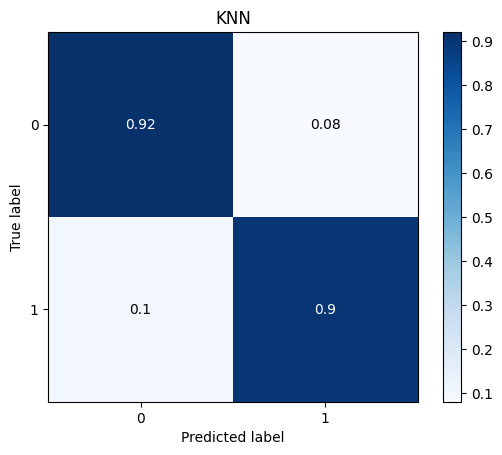

Gradient Boosting
time of fit : 132.86 seconds

Best Parameters : {'model__max_iter': 500}
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     11721
           1       0.97      0.95      0.96     14177

    accuracy                           0.96     25898
   macro avg       0.96      0.96      0.96     25898
weighted avg       0.96      0.96      0.96     25898



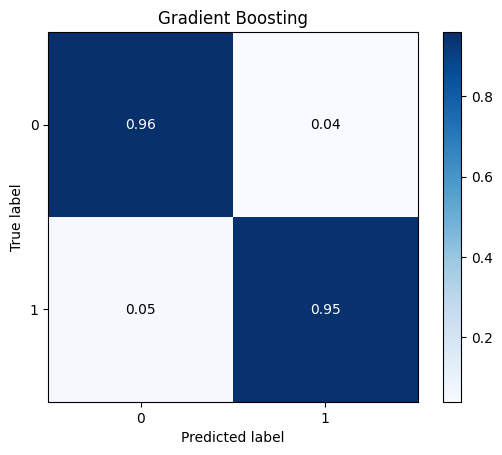

Random Forest
time of fit : 214.49 seconds

Best Parameters : {'model__n_estimators': 400}
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     11721
           1       0.97      0.95      0.96     14177

    accuracy                           0.96     25898
   macro avg       0.96      0.96      0.96     25898
weighted avg       0.96      0.96      0.96     25898



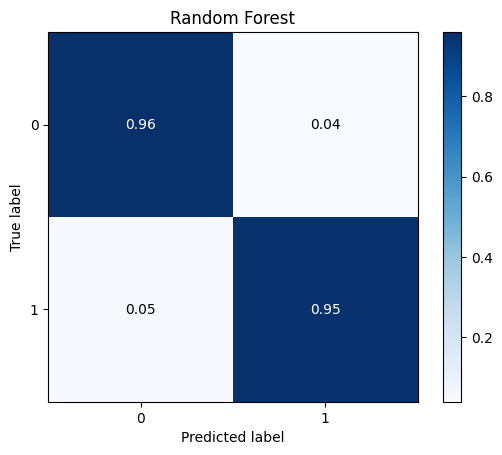

Extreme Boosting
time of fit : 86.25 seconds

Best Parameters : {'model__max_depth': 10}
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     11721
           1       0.97      0.96      0.96     14177

    accuracy                           0.96     25898
   macro avg       0.96      0.96      0.96     25898
weighted avg       0.96      0.96      0.96     25898



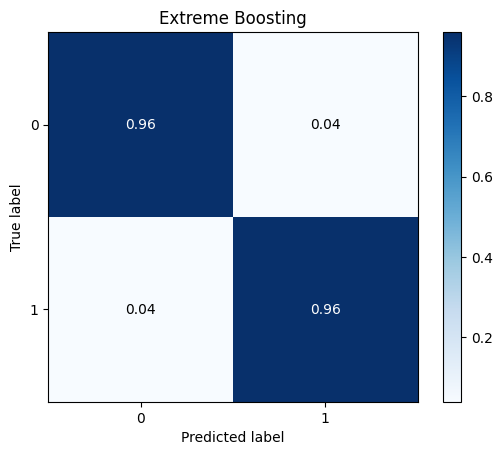

In [41]:
from utils import get_rapport_clf
get_rapport_clf(grid_list, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     11721
           1       0.97      0.95      0.96     14177

    accuracy                           0.96     25898
   macro avg       0.96      0.96      0.96     25898
weighted avg       0.96      0.96      0.96     25898



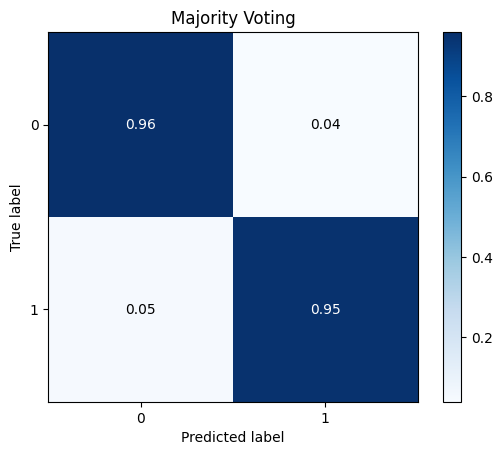

In [42]:
majority_clf = MajorityVoteClassifier([grid_rfc.best_estimator_, 
                                       grid_knn.best_estimator_, 
                                       grid_xbc.best_estimator_])
majority_clf.fit(X_train, y_train)
y_pred = majority_clf.predict(X_test)
print(classification_report(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, title='Majority Voting')
plt.show()

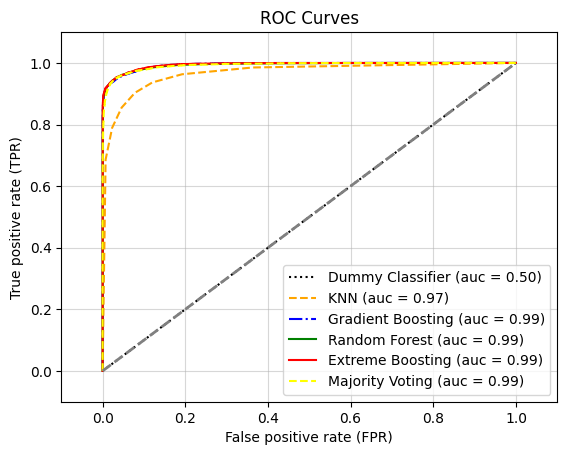

In [43]:
from sklearn.dummy import DummyClassifier
clf_labels = ['Dummy Classifier', 'KNN', 'Gradient Boosting', 'Random Forest', 'Extreme Boosting', 'Majority Voting']
all_clf = [DummyClassifier(), 
           grid_knn.best_estimator_, 
           grid_gbc.best_estimator_, 
           grid_rfc.best_estimator_, 
           grid_xbc.best_estimator_,
           majority_clf]

colors = ['black', 'orange', 'blue', 'green', 'red', 'yellow']
linestyles = [':', '--', '-.', '-', 'solid', 'dashed']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
# assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC Curves')
plt.show()

### Résultat de Grid search et de la Cross-validation
- L'ensemble des modèle testés obtiennent de très bon score sur l'ensemble des métriques de la classification
- Le random forest et les méthodes de Boosting obtiennent les meilleurs scores
- Bien que le knn dispose du score le plus bas mais il est aussi très rapide à entrainé

In [44]:
dfs = []
for clf, label in zip(all_clf, clf_labels):
    try:   
        model = clf.named_steps['model']
        feature_names = clf.named_steps['preparation'].get_feature_names_out()
        feature_importance = pd.Series({feature_names[i] : model.feature_importances_[i] for i in range(len(model.feature_importances_))})
        feature_importance = feature_importance.sort_values(ascending=False)
        dfs.append(feature_importance)
    except Exception as e:
        print(e)
        
[s[0:3] for s in dfs] # affiche les 3 features les plus importantes

'DummyClassifier' object has no attribute 'named_steps'
'KNeighborsClassifier' object has no attribute 'feature_importances_'
'HistGradientBoostingClassifier' object has no attribute 'feature_importances_'
'MajorityVoteClassifier' object has no attribute 'named_steps'


[tf_num__Inflight_entertainment    0.178559
 tf_num__Seat_comfort              0.136325
 tf_num__Ease_of_Online_booking    0.055597
 dtype: float64,
 tf_num__Inflight_entertainment          0.446802
 tf_num__Seat_comfort                    0.159217
 tf_cat__Customer_Type_Loyal Customer    0.068830
 dtype: float32]

In [45]:
dfs_to_plot = []
for s in dfs:
    df = pd.DataFrame({'names': dfs[0].index, 'values': dfs[0].values})
    dfs_to_plot.append(df)

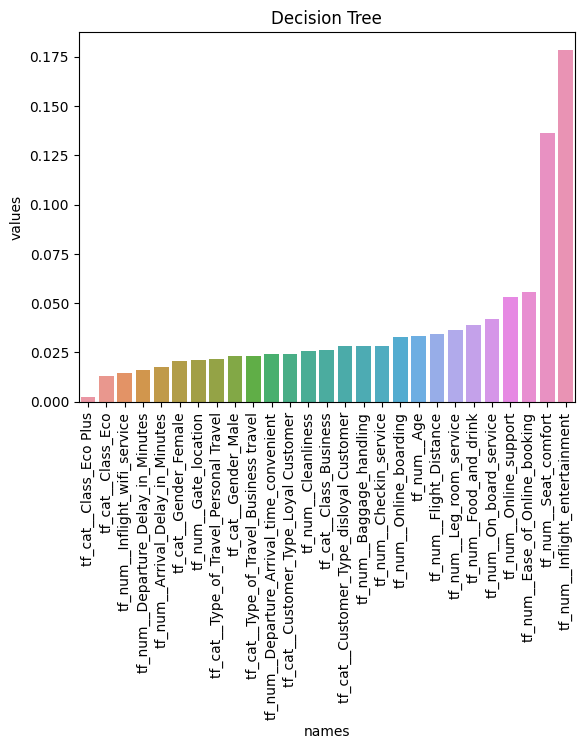

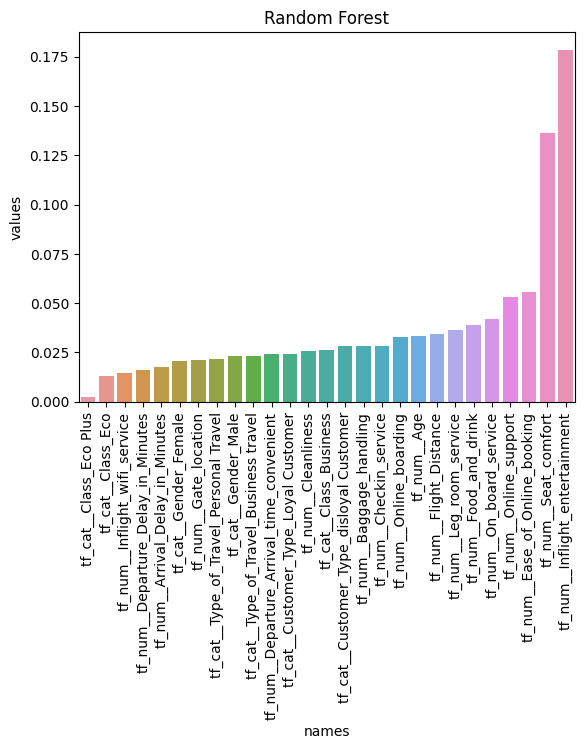

In [46]:
for df, title in zip(dfs_to_plot, ['Decision Tree','Random Forest', 'Extreme Boosting']):
    plt.figure()
    plt.xticks(rotation=90)
    sns.barplot(df.sort_values(by='values'), x='names', y='values').set(title=title)

### Importances des features
- Les features sont répartient selon une distribution de pareto
- Les deux features les plus importantes quelque soient le molèle sont le flight entertainement et le comfort du siège
- Bien que le confort du siège et la nourriture soient corrélées, ils n'ont pas du tout la même importance
- Globalement les résultats confirment les hypothèses posées lors de l'eda même si il y a quelques surprises 

## Interprétation des résultats
- Les variables les plus importantes sont les variables qui caractérisent le plus l'expérience d'un utilisateur
  - Le confort du siège, en effet, un passager passe la majeure partie du voyage assis
  - Le divertissement en vol est une variable qui s'est soustraite à notre attention lors de l'eda mais il s'agit de la variable la plus importante. Ce qui est logique a posteriori car un passager ennuyé est un passager insatisfait surtout pendant de long voyages
- Les modèles permettent une classification avec une accuracie élévé avec très un taux de classification érroné (faux positif, faux négatif) très faible
- Ces modèles sont donc capables de répondre aux besoins d'une companie aérienne qui voudrait classer les passagers selon leur degré de satisfaction récueilli au préalable par un questionnaire.